# Наумкин Владимир, С01-119.
# Домашнее задание 1.

## Сгенерируем вариант

In [18]:
from zlib import crc32
import numpy as np

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'}, 
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'}, 
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'}, 
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'}, 
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'}, 
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия', 
                          'Перцептрон', 
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия', 
                              'Перцептрон', 
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод Парзеновского окна', 
                              'SVM']}
task = dict()
task['mail'] = 'naumkin.vp@phystech.edu'
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(
    methods[task['type']], size=3, replace=False).tolist()


task

{'mail': 'naumkin.vp@phystech.edu',
 'id': 2913198394,
 'type': np.str_('classification'),
 'dataset': {'name': 'MNIST', 'url': 'http://yann.lecun.com/exdb/mnist/'},
 'method': ['k-ближайших соседей',
  'Метод потенциальных функций',
  'Перцептрон']}

## Возьмём датасет из torchvision и подключим остальные библиотеки

In [19]:
import torch
from torchvision import datasets
from torchvision import transforms

MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())


import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import classification_report
import IProgress
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist

## И убедимся, что в датасете находятся рукописные цифры

C:\Users\BOBA\AppData\Local\Temp\ipykernel_7944\2398159416.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')


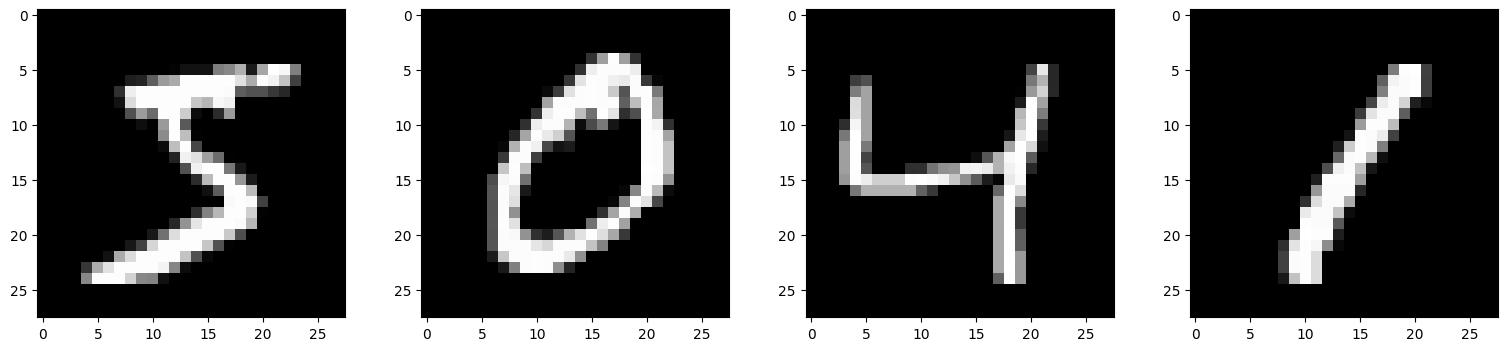

In [20]:
'''
import warnings
warnings.filterwarnings("ignore")
'''

fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')

plt.show()

## Посмотрим, в каком виде даны элементы

In [21]:
MNIST_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

In [22]:
type(MNIST_train[0])

tuple

In [23]:
MNIST_train[0][0].shape

torch.Size([1, 28, 28])

In [24]:
MNIST_train[0][1]

5

In [25]:
torch.max(MNIST_train[0][0])

tensor(1.)

In [26]:
torch.min(MNIST_train[0][0])

tensor(0.)

In [27]:
MNIST_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist
    Split: Test
    StandardTransform
Transform: ToTensor()

Выборка для тренировки имеет 60000 элементов, для проверки - 10000.
Элемент - это картинка в виде матрицы 28x28 интенсивности пикселей от 0 до 1 (от полностью чёрного нуля до полностью белой единицы - можно убедиться, если вывести MNIST_train[0], для компактности это не попало в финальный отчёт) и цифра, изображённая на картинке.

Таким образом, признаки - это 784 вещественных числа от 0 до 1, обозначающие интенсивность пикселей. Целевой признак - цифра от 0 до 9. Поэтому никакого дополнительного преобразования признаков и их нормировки не требуется, кроме трансформации в тензор на этапе загрузки датасета. Единственное, что нужно будет сделать для тренировки моделей - преобразовать матрицу в вектор, но это будет проделано ниже.
### ВНИМАНИЕ: название переменной X_train используется как в перцептроне, так и в остальных двух методах. Но этой переменной присваиваются разные значения! Возможно переиспользование некоторых переменных и дальше. Поэтому во избежание ошибок при попытке провести вычисления заново надо запускать клетки jupyter notebook в порядке их следования.

## Посмотрим, как выглядит каждая цифра в среднем

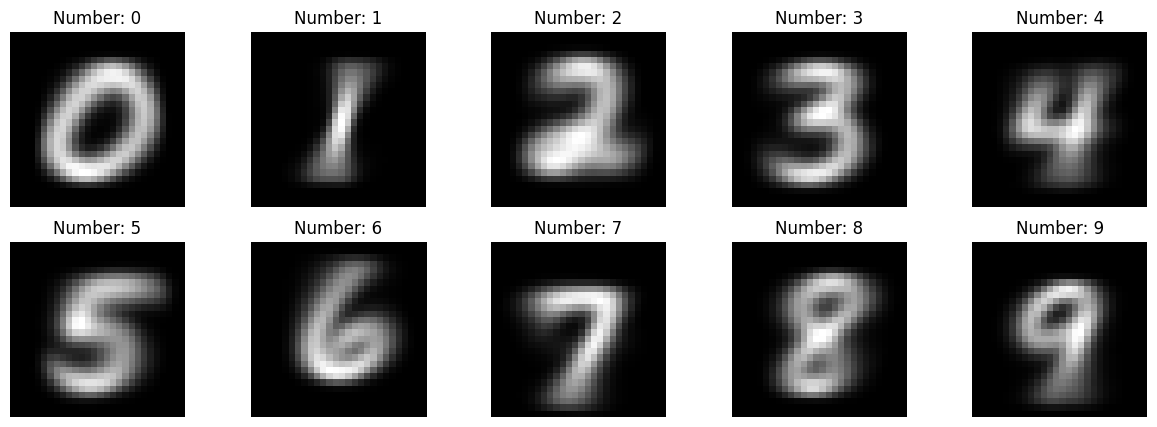

In [28]:
average = np.zeros((10, 28, 28), dtype = np.float64)
count = np.bincount(MNIST_train.targets, minlength = 10)
np.add.at(average, MNIST_train.targets, MNIST_train.data)
average /= count[:, None, None]
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(average[i], cmap='gray')
    plt.title(f'Number: {i}')
    plt.axis('off')
plt.show()

Можно сделать вывод о том, что рукописные цифры в датасете хорошо центрированы (правда, это было и так написано на официальном сайте датесета). Также, несмотря на различное написание цифр, их усреднённые картинки хорошо отличимы друг от друга и действительно соответствуют правильным ответам. Например, на самой первой картинке датасета изображена цифра 5 (см. выше), причём написание этой цифры доаольно небрежное. А усреднённое написание пятёрки очень хорошее, сразу понятно, какая цифра изображена.

Кстати, нелишним будет проверить, что доли каждой цифры в датасете примерно одинаковые. Выразим доли в процентах и убедимся, что на каждая из 10 цифр занимает примено 10 процентов выборки:

In [29]:
count * 100 / sum (count)

array([ 9.87166667, 11.23666667,  9.93      , 10.21833333,  9.73666667,
        9.035     ,  9.86333333, 10.44166667,  9.75166667,  9.915     ])

Итак, в силу особенностей исходных данных, как-то дополнительно их изменять, можно сказать, не требуется. Рисовать таблицу 784x784 графиков со всеми возможными парами осей для 10 видов цифр для данного датасета не имеет смысла. Зато нагядно можно показать, что в среднем каждая цифра пишется более-менее одинаково и отличимо от других цифр. Перейдём к реализации методов.

## Перцептрон

Начнём с последнего метода из сгенерированного списка. Перцептрон для этого датасета был разобран в 3 семинаре.

In [30]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [32]:
model = Perceptron()
model.to(device)

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [33]:
model = Perceptron(num_layers=1)
model.to(device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [34]:
model = Perceptron(num_layers=2)
model.to(device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [35]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = []
    real = []
    for x, y in generator:
        x = x.view([-1, 784]).to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [36]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                              shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [37]:
def draw_table(data, title=['ACCURACY'], width=[60, 11]):    
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'
    
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))

Для теста создадим перцептрон без скрытых слоёв:

In [39]:
model = Perceptron(num_layers=0)
model.to(device)

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [40]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.02      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.24      0.06      0.09      1032
           3       0.19      0.02      0.04      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.33      0.01      0.01       958
           7       0.10      0.82      0.17      1028
           8       0.05      0.04      0.05       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.09      0.09      0.04     10000
weighted avg       0.09      0.10      0.04     10000



Очевидно, модель не обучена. Обучим перцептрон:

In [41]:
_ = model.train()
trainer(model=model, 
        dataset=MNIST_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=4)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [43]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.91      0.86      0.88       892
           6       0.95      0.94      0.95       958
           7       0.94      0.91      0.92      1028
           8       0.86      0.90      0.88       974
           9       0.90      0.91      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Это был перцептрон без скрытых слоёв (линейная модель - частный случай полносвязного персептрона), и он уже даёт точность около 90 процентов. Подберём гиперпараметры (cross validation): количество скрытых слоёв, их размерность, а также параметр p, отвечающий за dropout. Скорость обучения трогать не будем.

In [44]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid({'num_layers': [0, 1, 2], 
                      'hidden_dim': [8, 64],
                      'p': [0.1, 0.3, 0.7],
                      'lr': [0.001]})

X_train = MNIST_train.transform(MNIST_train.data.numpy()).transpose(0,1)
Y_train = MNIST_train.targets.data

In [45]:
scores = dict()
for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(cross_val.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]

        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)

        model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                           hidden_dim=item['hidden_dim'])
        model.to(device)
        _ = model.train()
        trainer(model=model, 
                dataset=traindata, 
                loss_function=torch.nn.CrossEntropyLoss(), 
                optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']), 
                epochs=4)
        
        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [46]:
draw_table(scores)

+------------------------------------------------------------+-----------+
|                                                            |   ACCURACY|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.1}|       0.91|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|       0.92|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}|       0.92|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 1, 'p': 0.1}|        0.9|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 1, 'p': 0.3}|       0.88|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr

Проанализируем полученные результаты. Размерность скрытого слоя 64 при прочих равных всегда как миниимум не хуже, чем 8. Значит, рассмотрим только размерности 64. Среди них точность наибольшая при добавлении только одного скрытого слоя, а если добавить второй, то ничего не улучшится и даже ухудшится в одном случае (в отличие от размерностей 8, где рост числа слоёв ведёт только к ухудшению качества классификации). Наконец, чем меньше параметр p, тем больше точность, поэтому возьмём p = 0.1. В такой конфигурации перцептрон даёт точность 96 процентов.

Исходя из результатов можно сказать, что лучше выбирать параметр p поменьше, а также предположить, что размерность скрытого слоя лучше взять побольше (но нужно не забывать про размерность пространства признаков; в данном случае она равна 784 и ощутимо больше, чем анализируемые размерности скрытого слоя 8 и 64; вероятно, слишком большую размерность скрытого слоя, приближающуся к размерности пространства признаков, брать не стоит), и количество скрытых слоёв тоже можно увеличить (опять же, увеличивать не сильно, ориентируясь на размерность скрытого слоя).

Несколько теоретических слов про скорость обучения. Высокая скорость обучения может привести к нестабильности в процессе обучения, а маленькая - к слишком медленной сходимости. В данном анализе скорость обучения не изменялась и оставалась равной значению по умолчанию.

# k-ближайших соседей

In [47]:
kNN_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'leaf_size': [3, 15, 30, 45]}

X_train = np.array([np.array(MNIST_train[i][0][0]) for i in range(len(MNIST_train))]).reshape(-1, 28 * 28)
y_train = np.array(MNIST_train.targets)
X_test = np.array([np.array(MNIST_test[i][0][0]) for i in range(len(MNIST_test))]).reshape(-1, 28 * 28)
y_test = np.array(MNIST_test.targets)

C:\Users\BOBA\AppData\Local\Temp\ipykernel_7944\3483597813.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_train = np.array([np.array(MNIST_train[i][0][0]) for i in range(len(MNIST_train))]).reshape(-1, 28 * 28)
C:\Users\BOBA\AppData\Local\Temp\ipykernel_7944\3483597813.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_train = np.array(MNIST_train.targets)
C:\Users\BOBA\AppData\Local\Temp\ipykernel_7944\3483597813.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_test = np.array([np.array(MNIST_test[i][0][0]) for i in range(len(MNIST_test))]).reshape(-1, 28 * 28)
C:\Users\BOBA\AppData\Local\Temp\ipykerne

### Замечание: код ниже отрабатывает за 1133 секунд (почти 20 минут) на 8 процессах полностью загруженного ЦП AMD Ryzen 5 3400G with Radeon Vega Graphics, по 200 МБ ОЗУ на каждый процесс.

In [48]:
gr_s = GridSearchCV(KNeighborsClassifier(), kNN_grid, n_jobs = -1, verbose = 2)
gr_s.fit(X_train, y_train)
print(f'The best hyperparameters (accuracy: {gr_s.best_score_:.3f}):')
print(gr_s.best_params_)
kNN = gr_s.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best hyperparameters (accuracy: 0.970):
{'leaf_size': 3, 'n_neighbors': 3}


In [49]:
kNN_predict = kNN.predict(X_test)
print(classification_report(y_test, kNN_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Итак, для метода k-ближайших соседей из перебираемых вариантов гиперпараметров наилучшими оказались количество соседей и параметр leaf_size равными 3. Такая модель даёт точность 97 процентов, что лучше, чем получилось в перцептроне. Отмечу, что и подбор гиперпараметров (вместе с обучением) занял больше вычислительного времени (чем перцептрон), причём ЦП был загружен на 100 процентов.

## Метод потенциальных функций

### Обучение этой модели идёт ОЧЕНЬ долго, перезапускать не рекомендуется (см. комментарии сколько времени занял каждый этап обучения)

Подсмотрим реализацию метода в 4 семинаре, только увеличим количество классов с 2 до 10:

In [50]:
class PFM(object):
    def __init__(self, kernel=None):
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
    def scores(self, X):
        features = self.gams*self.kernel(cdist(X, self.X))
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==i)[0]].T, axis=-1) for i in range(10)]).T
        return scores
    def predict(self, X):
        return np.argmax(self.scores(X), axis=-1)
    def fit(self, X, Y, epoch=10):
        self.X, self.Y, self.gams = np.array(X), np.array(Y), np.zeros_like(Y)
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

In [51]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

Выберем из 60000 тренировочных данных первую тысячу для обучения и вторую тысячу для проверки, чтобы прикинуть, в каком районе надо подбирать h. Для каждого варианта h обучение на 1000 объектов происходит примерно за 30 секунд.

In [57]:
for h in [0.05, 1, 10, 50]:
    model = PFM(kernel=lambda x: K(x, h=h))
    model.fit(X_train[:1000:], y_train[:1000:])
    y_pred = model.predict(X_train[1000:2000:])
    print('h = ' + str(h))
    print(set(y_pred))
    print(classification_report(y_train[1000:2000:], y_pred))

h = 0.05
{np.int64(0)}
              precision    recall  f1-score   support

           0       0.09      1.00      0.17        94
           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00       109
           5       0.00      0.00      0.00        88
           6       0.00      0.00      0.00       106
           7       0.00      0.00      0.00       107
           8       0.00      0.00      0.00        85
           9       0.00      0.00      0.00       110

    accuracy                           0.09      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.09      0.02      1000



C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

h = 1
{np.int64(0)}
              precision    recall  f1-score   support

           0       0.09      1.00      0.17        94
           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00       109
           5       0.00      0.00      0.00        88
           6       0.00      0.00      0.00       106
           7       0.00      0.00      0.00       107
           8       0.00      0.00      0.00        85
           9       0.00      0.00      0.00       110

    accuracy                           0.09      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.09      0.02      1000



C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BOBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

h = 10
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}
              precision    recall  f1-score   support

           0       0.97      0.74      0.84        94
           1       0.94      0.85      0.89       104
           2       0.72      0.77      0.75        99
           3       0.93      0.64      0.76        98
           4       0.83      0.78      0.81       109
           5       0.68      0.78      0.73        88
           6       0.89      0.93      0.91       106
           7       0.88      0.88      0.88       107
           8       0.76      0.79      0.77        85
           9       0.65      0.90      0.76       110

    accuracy                           0.81      1000
   macro avg       0.83      0.81      0.81      1000
weighted avg       0.83      0.81      0.81      1000

h = 50
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.i

Итак, слишком малым h брать нельзя (например, 0.05 или 1), иначе модель всегда предсказывает единственную цифру 0. Слишком большим (например, 50) - тоже, т.к. результат ухудшается. А вот выбрать h около 10 показалось наилучшим решением. Попробуем для выбранных (расположенных около 10) h поварьировать параметр epoch. Снова используем только 1000 первых объектов для обучения и следующую 1000 для проверки. Попытаемся распараллелить на потоки для ускорения обучения, которое заняло в сумме около 3 минут.

In [59]:
import concurrent.futures

def my_func(e, h):
    model = PFM(kernel=lambda x: K(x, h=h))
    model.fit(X_train[:1000:], y_train[:1000:], e)
    y_pred = model.predict(X_train[1000:2000:])
    print('h = ' + str(h) + ', epoch = ' + str(e) + '\n' + classification_report(y_train[1000:2000:], y_pred))

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for e in [5, 10, 15]:
        for h in [5, 10, 15]:
            futures.append(executor.submit(my_func, e, h))
    for future in concurrent.futures.as_completed(futures):
        future.result()

h = 5, epoch = 5
              precision    recall  f1-score   support

           0       0.12      1.00      0.22        94
           1       0.99      0.88      0.93       104
           2       1.00      0.04      0.08        99
           3       1.00      0.06      0.12        98
           4       1.00      0.11      0.20       109
           5       1.00      0.07      0.13        88
           6       1.00      0.16      0.28       106
           7       0.98      0.45      0.62       107
           8       1.00      0.08      0.15        85
           9       0.97      0.31      0.47       110

    accuracy                           0.32      1000
   macro avg       0.91      0.32      0.32      1000
weighted avg       0.91      0.32      0.33      1000

h = 15, epoch = 5
              precision    recall  f1-score   support

           0       0.96      0.72      0.82        94
           1       0.99      0.79      0.88       104
           2       0.76      0.79      0.78

Видим, что при h = 5 точность определения цифры 0 очень низкая - всего лишь 12 процентов. Поэтому исключим этот вариант из рассмотрения. Обучение идёт очень долго, поэтому сделаем финальный подбор параметров, обучив каждую модель на 5000 первых объектов и проверив на следующих 5000 объектов (изначально была попытка проверить на всех остальных тренировочных данных, но через час работы не хватило ОЗУ для предсказания оставшихся 55000 объектов). По результатам будет выбрана наилучшая комбинация h и epoch, итоговая модель будет обучена на большем количестве тренировочных данных и проверена на тестовых.

In [61]:
def my_func(e, h):
    model = PFM(kernel=lambda x: K(x, h=h))
    model.fit(X_train[:5000:], y_train[:5000:], e)
    y_pred = model.predict(X_train[5000:10000:])
    print('h = ' + str(h) + ', epoch = ' + str(e) + '\n' + classification_report(y_train[5000:10000:], y_pred))

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for e in [5, 10, 15]:
        for h in [10, 15]:
            futures.append(executor.submit(my_func, e, h))
    for future in concurrent.futures.as_completed(futures):
        future.result()

h = 15, epoch = 5
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       522
           1       0.97      0.91      0.94       564
           2       0.78      0.86      0.82       503
           3       0.76      0.84      0.80       539
           4       0.90      0.85      0.87       445
           5       0.65      0.86      0.74       429
           6       0.97      0.84      0.90       513
           7       0.91      0.86      0.88       520
           8       0.78      0.82      0.80       482
           9       0.83      0.81      0.82       483

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.84      5000
weighted avg       0.86      0.84      0.85      5000

h = 10, epoch = 5
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       522
           1       0.86      0.95      0.90       564
           2       0.90      0.83      0.8

Результаты были получены через час. Наилучшего результата удалось добиться при h = 10, epoch = 5. Обучим окончательно именно эту модель и проверим на тестовой выборке. Если за ночь (за 12 часов) модель не закончит обучение на всей тренировочной выборке, будет опять взята какая-то её часть.

#### Я из будущего говорю, что в целом всё получилось, так что не обращаем внимания на сообщение об ошибке ниже и смотрим дальше.

In [69]:
e = 5
h = 10
final = PFM(kernel=lambda x: K(x, h=h))
final.fit(X_train, y_train, e)
y_pred = final.predict(X_test)
print('h = ' + str(h) + ', epoch = ' + str(e) + '\n' + classification_report(y_test, y_pred))

MemoryError: Unable to allocate 4.47 GiB for an array with shape (10000, 60000) and data type float64

Модель обучилась за 14 часов, но на этапе проверки не хватило ОЗУ для проверки всей тренировочной выборки. Проверим несколько первых объектов тестовой выборки:

In [73]:
final.predict(X_test[0:10:])

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [74]:
y_test[0:10:]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

На первых 10 объектах только одна ошибка: перепутали 5 с 6. Выглядит не очень страшно. Попытаемся ещё раз проверить всю тестовую выборку, может быть память не успела освободиться (не пугаемся ошибки и читаем её - на самом деле не хватает места только для 784 из 10000 элементов):

In [79]:
print('h = ' + str(h) + ', epoch = ' + str(e) + '\n' + classification_report(y_test, final.predict(X_test)))

MemoryError: Unable to allocate 359. MiB for an array with shape (60000, 784) and data type float64

Странно, что при 9000 объектах ошибка сохраняется (не попало в итоговый отчёт). Проверим сначала 100 тестовых объектов:

In [83]:
print('h = ' + str(h) + ', epoch = ' + str(e) + '\n' + classification_report(y_test[:100:], final.predict(X_test[:100:])))

h = 10, epoch = 5
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.93      0.93      0.93        14
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00        11
           4       1.00      0.79      0.88        14
           5       0.75      0.86      0.80         7
           6       0.90      0.90      0.90        10
           7       0.93      0.93      0.93        15
           8       1.00      1.00      1.00         2
           9       0.85      1.00      0.92        11

    accuracy                           0.92       100
   macro avg       0.92      0.93      0.92       100
weighted avg       0.93      0.92      0.92       100



Потом 1000:

In [86]:
print('h = ' + str(h) + ', epoch = ' + str(e) + '\n' + classification_report(y_test[:1000:], final.predict(X_test[:1000:])))

h = 10, epoch = 5
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        85
           1       0.93      0.90      0.92       126
           2       0.91      0.83      0.86       116
           3       0.91      0.89      0.90       107
           4       0.89      0.87      0.88       110
           5       0.75      0.87      0.81        87
           6       0.90      0.91      0.90        87
           7       0.87      0.86      0.86        99
           8       0.83      0.79      0.81        89
           9       0.83      0.90      0.86        94

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



К сожалению, цифра 5 плохо определяется. Это было видно с самого начала. Всё же получим итоговый результат, разбив тестовую выборку на 10 кусков по 1000 объектов.

In [93]:
finally_predict = np.ndarray(0)
print("Processing part number ", end = '')
for i in range(10):
    print(i + 1, end = ' ')
    finally_predict = np.concatenate((finally_predict, final.predict(X_test[i * 1000 : (i + 1) * 1000 :])), axis = None)
print(". Done!")

Processing part number 1 2 3 4 5 6 7 8 9 10 . Done!


In [95]:
print(classification_report(y_test, finally_predict))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       980
           1       0.92      0.94      0.93      1135
           2       0.93      0.88      0.90      1032
           3       0.92      0.91      0.92      1010
           4       0.90      0.92      0.91       982
           5       0.83      0.86      0.84       892
           6       0.94      0.92      0.93       958
           7       0.94      0.90      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.88      0.92      0.90      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Итак, точность итоговой модели равна 91 проценту. Последний метод реализован, перейдём к выводам.

# Результаты

Повторим основные моменты работы. Датасет MNIST рукописных цифр содержит матрицы интенсивностей размером 28 на 28. Поэтому почти никаких преобразований исходных данных не потребовалось, все признаки и так числовые и нормализуются банальным делением на максимальную интенсивность 255 (для выполнения работы достаточно было преобразовать в тензор на этапе загрузки датасета). Понадобилось только превратить матрицы в векторы для обучения моделей. Также было показано "среднее" написание цифр.

Перейдём к обсуждению моделей. Для перцептрона и kNN с помощью кросс-валидации были получены итоговые модели с отличной точностью - 96 и 97 процентов соответственно. Суммарно было затрачено менее часа вычислительного времени на получение итоговых моделей этих двух методов. Перцептрон обучился немного быстрее, но точность чуть-чуть хуже, чем kNN.

Отдельного внимания заслуживает метод потенциальных функций. Из-за отсутствия библиотечного варианта он был написан вручную. В силу очень долгого обучения подбор гиперпараметров происходил только на части тренировочной выборки в несколько этапов, ни о какой кросс-валидации речи не шло (но проверялось по-честному без использования тестовой выборки). В итоге самый перспективный вариант окончательно обучался на всей тренировочной выборке 14 часов, а для проверки результата тестовую выборку пришлось разделить на 10 частей. И всё ради 91 процента точности, что на 1 процент меньше простейшего перцептрона, обученного за пару минут. Напоследок отмечу, что почему-то цифра 5 определяется этой моделью заметно хуже остальных цифр (вероятно, часто путается с 6), цифры 8 и 9 тоже показывают плохой результат (вероятно, путаются между собой).
Итак, метод потенциальных функций показал себя очень и очень плохо во всём. В лекции 4 говорилось, что этот метод не сходится для большого количества признаков, а у нас их аж 28 * 28 = 784 штуки, поэтому такой плохой результат ожидаем. Всё же удалось получить точность 91 процент.

Перцептрон и kNN показали себя отлично. Быстрое обучение, высокая точность предсказаний, кросс-валидация, готовая библиотечная реализация - всё это про эти модели. Если всё же сравнивать эти методы, то перцептрон оказался немного хуже - как по точности, так и по сложности реализации (использовался torch и свой класс в отличие от kNN через sklearn). И раз уж в отчёте про kNN было написано меньше всего, то закончу работу именно словами об этом методе. Он объективно показал себя точнее остальных методов и субъективно понравился мне больше всего простотой реализации. Лучше бы время, потраченное на обучения метода потенциальных функций, я уделил на более тщательный подбор гиперпараметров модели kNN.